In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#Reading the files
data_2019 = pd.read_csv(r'C:\Users\Admin\Downloads\2019_kdi.csv')
data_2020 = pd.read_csv(r'C:\Users\Admin\Downloads\2020_kdi.csv')

In [2]:
# Convert the 'transactionDate' column in the 2019 data to datetime format to enable time series analysis.
data_2019['transactionDate'] = pd.to_datetime(data_2019['transactionDate'])

# Convert the 'ItemQuantity' column in the 2019 data to a numeric type, forcing any non-numeric values to NaN (errors='coerce').
data_2019['ItemQuantity'] = pd.to_numeric(data_2019['ItemQuantity'], errors='coerce')

# Similar to the 2019 data, convert the 'transactionDate' column in the 2020 data to datetime format for consistent time series analysis.
data_2020['transactionDate'] = pd.to_datetime(data_2020['transactionDate'])

# Again, for the 2020 data, convert 'ItemQuantity' to numeric, coercing errors to NaN for any problematic values that can't be converted to numbers.
data_2020['ItemQuantity'] = pd.to_numeric(data_2020['ItemQuantity'], errors='coerce')

In [3]:
# Combine the data
data_combined = pd.concat([data_2019, data_2020], ignore_index=True)

In [4]:
# Group the combined data by 'SKU_UPC' and sum up the 'ItemQuantity' for each group. 
# Then reset the index to convert the result from a groupby object to a DataFrame.
sku_quantity_analysis = data_combined.groupby('SKU_UPC')['ItemQuantity'].sum().reset_index()

# Sort the resulting DataFrame 'sku_quantity_analysis' by 'ItemQuantity' in descending order to identify the SKUs with the highest quantities.
sku_quantity_analysis_sorted = sku_quantity_analysis.sort_values('ItemQuantity', ascending=False)

In [5]:
print(sku_quantity_analysis_sorted)

        SKU_UPC  ItemQuantity
36  81153801198         26352
8   81153801083         22470
9   81153801085         21440
6   81153801076         16387
37  81153801199         12713
7   81153801077         12096
18  81153801099          9968
16  81153801096          7845
31  81153801173          3902
19  81153801100          3880
21  81153801103          3424
32  81153801174          2773
14  81153801094          2762
13  81153801092          2259
51  81153801376          1585
47  81153801330          1509
46  81153801283          1491
11  81153801089          1456
28  81153801155          1364
48  81153801331          1317
26  81153801137          1179
27  81153801142          1111
53  81153801481           804
30  81153801160           649
23  81153801107           552
17  81153801097           519
20  81153801101           495
58  81153801876           459
45  81153801259           402
10  81153801088           329
34  81153801179           324
15  81153801095           247
57  811538

In [6]:
threshold = 10000

# Inventory Forecasting Function

In [7]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [8]:
# Define a function to forecast sales quantity for a given SKU/UPC if it meets a specified sales threshold.
def forecast_sku(sku_upc, threshold=10000):
    
    # Calculate the total item quantity sold for the given SKU/UPC in the combined dataset.
    total_quantity = data_combined[data_combined['SKU_UPC'] == sku_upc]['ItemQuantity'].sum()
    
    # Check if the total quantity sold for the SKU/UPC exceeds the specified threshold.
    if total_quantity > threshold:
        print(f"SKU {sku_upc} exceeds the threshold with a total sales quantity of {total_quantity}. Proceeding with forecasting...")
        
        # Filter the data for the specific SKU/UPC.
        sku_data = data_combined[data_combined['SKU_UPC'] == sku_upc]
        
        # Group the SKU data by transaction date and sum the item quantities, then reset the index to create a DataFrame.
        sku_data = sku_data.groupby('transactionDate')['ItemQuantity'].sum().reset_index()
        
        # Rename the columns to 'ds' and 'y' to fit the Prophet model requirements ('ds' for datestamp, 'y' for the variable to predict).
        sku_data.columns = ['ds', 'y']
        
        # Initialize the Prophet model with specified parameters.
        m = Prophet(interval_width=0.95, daily_seasonality=False, yearly_seasonality=True)
        
        # Fit the model to the SKU data.
        m.fit(sku_data)
        
        # Create a DataFrame for future dates extending 90 days beyond the last available date in the data for prediction purposes.
        future = m.make_future_dataframe(periods=90, freq='D')
        
        # Use the model to make predictions for the future dates.
        forecast = m.predict(future)
        
        # Print the forecasted values.
        print(forecast[['ds', 'yhat']])
        
        # Plot the forecast results to visualize the predicted sales quantity over time.
        fig = m.plot(forecast)
        plt.title(f'Sales Forecast for SKU {sku_upc}')
        plt.xlabel('Date')
        plt.ylabel('Sales Quantity')
        
        # Plot the components of the forecast to analyze trends and seasonal effects.
        fig2 = m.plot_components(forecast)
    else:
        # If the SKU/UPC does not meet the threshold, print a message and do not perform the forecasting.
        print(f"SKU {sku_upc} does not meet the threshold with a total sales quantity of {total_quantity}. No forecasting performed.")

SKU 81153801198 exceeds the threshold with a total sales quantity of 26352. Proceeding with forecasting...


01:15:53 - cmdstanpy - INFO - Chain [1] start processing
01:15:53 - cmdstanpy - INFO - Chain [1] done processing


            ds       yhat
0   2019-01-01  31.701160
1   2019-01-02  31.126264
2   2019-01-03  33.427962
3   2019-01-04  38.126505
4   2019-01-05  38.987611
..         ...        ...
811 2021-03-27  41.780688
812 2021-03-28  32.943691
813 2021-03-29  29.920536
814 2021-03-30  32.908153
815 2021-03-31  32.768209

[816 rows x 2 columns]


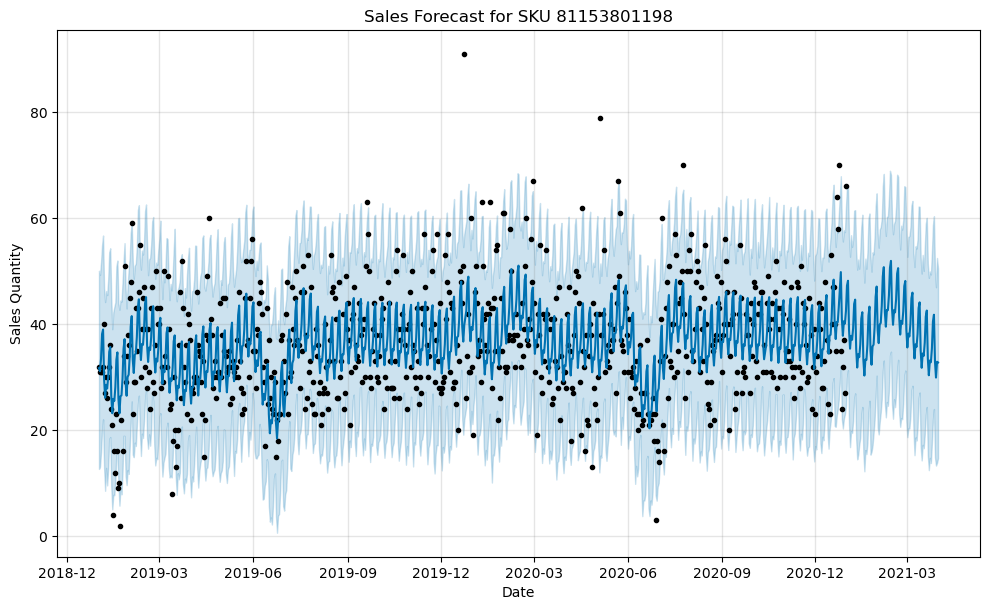

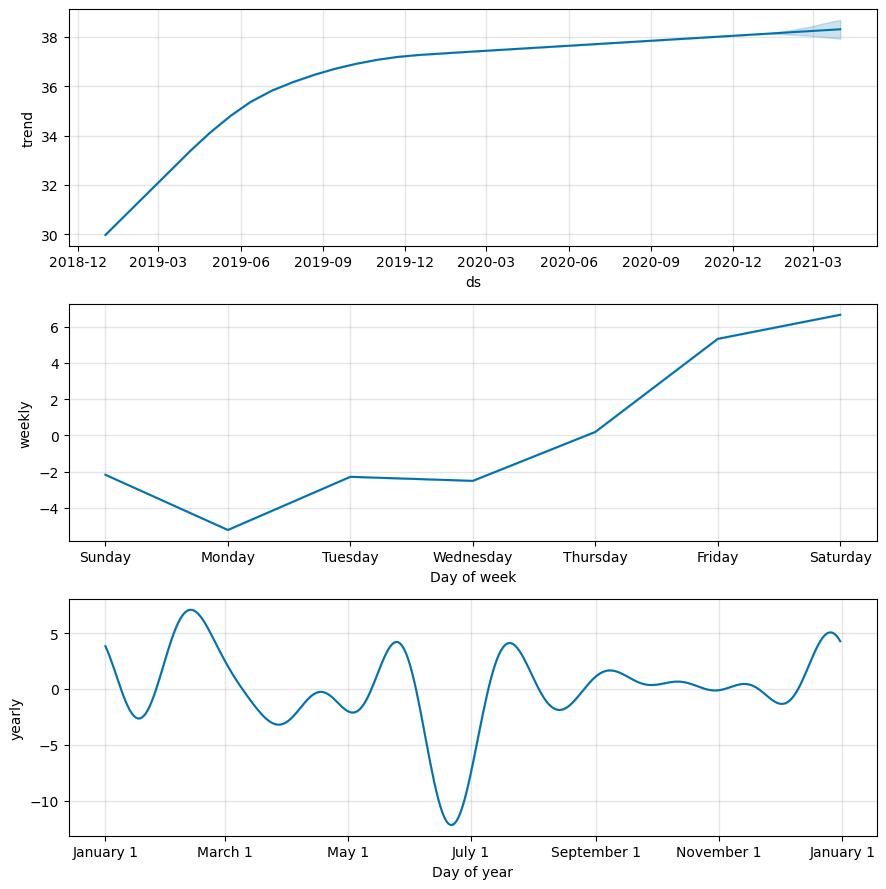

In [9]:
forecast_sku(sku_upc=81153801198, threshold=10000)

In [10]:
# Extract the unique SKU/UPC values from the 'SKU_UPC' column in the 'data_combined' DataFrame, and convert these unique values into a list. This list, 'sku_upc_list', will contain each unique SKU/UPC
# value once, which can be used for iterating over different SKUs/UPCs for analysis or processing.
sku_upc_list = data_combined['SKU_UPC'].unique().tolist()

In [12]:
import pandas as pd
from prophet import Prophet
import os
import json
from datetime import datetime

# Assume data_combined is properly prepared with necessary conversions already done
def forecast_sales(df, period):
    # Ensure 'ItemPrice' is numeric, converting any non-numeric values to NaN
    df['ItemPrice'] = pd.to_numeric(df['ItemPrice'], errors='coerce')

    # Drop any rows where 'ItemPrice' is NaN since they cannot be used in calculations
    df = df.dropna(subset=['ItemPrice'])
    
    # Rename columns to fit Prophet's expectations
    df = df.rename(columns={'transactionDate': 'ds', 'ItemQuantity': 'y', 'ItemPrice': 'item_price'})

    # Convert 'ds' to datetime if not already
    df['ds'] = pd.to_datetime(df['ds'])

    # Initialize the Prophet model with specified parameters
    model = Prophet(interval_width=0.95, daily_seasonality=False, yearly_seasonality=True)

    # Fit the model using the date and quantity columns
    model.fit(df[['ds', 'y']])

    # Generate future date points for the specified period with a monthly frequency
    future = model.make_future_dataframe(periods=period, freq='M')

    # Use the model to predict future values based on the generated dates
    forecast = model.predict(future)

    # Prepare the response dictionary with the forecast results
    response = {
        "status": "success",
        "data": []
    }

    # Cycle through item prices from the input data for future forecast months
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(period)
    for index, row in forecast.iterrows():
        estimated_price = df.iloc[index % len(df)]['item_price']  # Assume cycling through prices
        response['data'].append({
            "month": row['ds'].strftime('%B'),
            "quantity": int(row['yhat']),
            "min_quantity": int(row['yhat_lower']),
            "max_quantity": int(row['yhat_upper']),
            "revenue": int(row['yhat'] * estimated_price),
            "min_revenue": int(row['yhat_lower'] * estimated_price),
            "max_revenue": int(row['yhat_upper'] * estimated_price)
        })

    return response

# Call the forecast function to predict sales for the next 6 months using data_combined
forecast_results = forecast_sales(data_combined, 6)

# Get the current working directory
current_directory = os.getcwd()

# Construct the file path for saving the forecast results in HTML format
file_path = os.path.join(current_directory, "forecast_results.html")

# Define a custom function to convert datetime objects to strings for JSON serialization
def convert(o):
    if isinstance(o, datetime):
        return o.__str__()

# Open the file at the specified path in write mode and write the forecast results in HTML format
with open(file_path, "w") as file:
    file.write("<html><head><title>Forecast Results</title></head><body><pre>\n")
    json_output = json.dumps(forecast_results, default=convert, indent=4)
    file.write(json_output)
    file.write("\n</pre></body></html>")
    
# Print the location of the saved forecast results file
print(f"The forecast results file is saved at: {file_path}")


01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:34 - cmdstanpy - INFO - Chain [1] done processing


The forecast results file is saved at: C:\Users\Admin\Downloads\forecast_results.html


In [13]:
import pandas as pd
from prophet import Prophet

# Function to simulate inventory forecasting
def inventory_forecast(period, available_quantity, reorder_level, avg_time_to_deliver, input_data):
    # Convert input data to DataFrame and format for Prophet
    df = pd.DataFrame(input_data)
    df['ds'] = pd.to_datetime(df['date'], format="%d-%m-%Y")
    df['y'] = df['quantity']
    
    # Initialize and fit the Prophet model
    model = Prophet(interval_width=0.95, daily_seasonality=False, yearly_seasonality=True)
    model.fit(df[['ds', 'y']])
    
    # Create future DataFrame for the specified period (in months)
    future = model.make_future_dataframe(periods=period, freq='M')
    forecast = model.predict(future)
    
    # Prepare response and initial setup
    response = {"status": "success", "data": []}
    inventory = available_quantity
    orders_pending = []

    for month_end in future['ds']:
        month_name = month_end.strftime('%B')
        # Get forecast for the specific month
        monthly_forecast = forecast[(forecast['ds'] >= month_end.replace(day=1)) & (forecast['ds'] <= month_end)]
        expected_sales = monthly_forecast['yhat'].sum()

        # Update inventory for received orders
        inventory += sum(order['quantity'] for order in orders_pending if order['order_date'] <= month_end)
        orders_pending = [order for order in orders_pending if order['order_date'] > month_end]

        # Update inventory based on expected sales
        inventory -= expected_sales
        order_recommendations = []

        # Check inventory and recommend orders
        if inventory < reorder_level:
            order_qty = (reorder_level + expected_sales - inventory)  # ensure enough inventory for next period
            order_date = month_end + pd.DateOffset(days=avg_time_to_deliver)
            order_recommendations.append({"order_date": order_date.strftime("%Y-%m-%d"), "quantity": order_qty})
            orders_pending.append({"order_date": order_date, "quantity": order_qty})
            inventory += order_qty  # assume the order is placed, not received

        # Append data for the month
        response['data'].append({
            "month": month_name,
            "inventory_level": max(inventory, 0),
            "order_recommendations": order_recommendations
        })

    return response

# Input data example
request_body = {
    "period": 6,  # Forecast for 6 months
    "available_quantity": 100,
    "reorder_level": 50,
    "avg_time_to_deliver": 30,  # Reduced average time to delivery for quicker response
    "input_data": [
        {"date": "01-01-2023", "quantity": 100},
        {"date": "01-02-2023", "quantity": 70},
        {"date": "01-03-2023", "quantity": 120},
        {"date": "01-04-2023", "quantity": 101},
        {"date": "01-05-2023", "quantity": 50}
    ]
}

# Generate forecast
forecast_results = inventory_forecast(
    period=request_body['period'],
    available_quantity=request_body['available_quantity'],
    reorder_level=request_body['reorder_level'],
    avg_time_to_deliver=request_body['avg_time_to_deliver'],
    input_data=request_body['input_data']
)

# Print forecast results
print(forecast_results)


01:37:27 - cmdstanpy - INFO - Chain [1] start processing
01:37:27 - cmdstanpy - INFO - Chain [1] done processing


{'status': 'success', 'data': [{'month': 'January', 'inventory_level': 149.99991387905112, 'order_recommendations': [{'order_date': '2023-01-31', 'quantity': 149.99982775810224}]}, {'month': 'February', 'inventory_level': 230.00018251787523, 'order_recommendations': []}, {'month': 'March', 'inventory_level': 109.99939387533023, 'order_recommendations': []}, {'month': 'April', 'inventory_level': 150.99924941183696, 'order_recommendations': [{'order_date': '2023-05-01', 'quantity': 141.9991049483437}]}, {'month': 'May', 'inventory_level': 242.99868571120675, 'order_recommendations': []}, {'month': 'May', 'inventory_level': 59.11400242848748, 'order_recommendations': []}, {'month': 'June', 'inventory_level': 285.40320515037286, 'order_recommendations': [{'order_date': '2023-07-30', 'quantity': 461.69240787225823}]}, {'month': 'July', 'inventory_level': 1514.1316622115176, 'order_recommendations': [{'order_date': '2023-08-30', 'quantity': 2231.167711400404}]}, {'month': 'August', 'inventor